In [1]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np


# Get current notebook directory
root = Path().resolve()

# Go up one level (since your notebook is inside "notebooks")
project_root = root.parent
processed_root = project_root / "data_processed"
models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Discover classes (sorted for stable label order)
if not processed_root.exists():
    raise FileNotFoundError(f"❌ data_processed not found at: {processed_root}")

classes = sorted([p.name for p in processed_root.iterdir() if p.is_dir()])
num_classes = len(classes)
print("✅ Found data folder:", processed_root)
print("Classes detected:", num_classes)


✅ Found data folder: C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\data_processed
Classes detected: 47


In [2]:
def clean_path(p: Path) -> str:
    # Safe, OS-agnostic paths for tf.data
    return str(p).replace("\\", "/")

def get_paths_and_labels(class_names, split):
    paths, labels = [], []
    for idx, cls in enumerate(class_names):
        class_dir = processed_root / cls / split
        if not class_dir.exists(): 
            continue
        for img_path in class_dir.glob("*"):
            # Skip folders and hidden files (like .ipynb_checkpoints)
            if img_path.is_dir() or img_path.name.startswith("."):
                continue
            paths.append(clean_path(img_path))
            labels.append(idx)
    return paths, labels

train_paths, train_labels = get_paths_and_labels(classes, "train")
val_paths,   val_labels   = get_paths_and_labels(classes, "val")
test_paths,  test_labels  = get_paths_and_labels(classes, "test")

print("Counts:", len(train_paths), len(val_paths), len(test_paths))


Counts: 10332 2198 2260


In [3]:
# IMPORTANT: We will NOT divide by 255. We'll keep uint8 [0,255] to feed preprocess_input later.

def augment_numpy(image_np, rng=None):
    """Sane-strength Pi-like augmentation: light crop/zoom, brightness/contrast,
    mild JPEG artifacts, gentle blur, very light vignette. Returns uint8 image."""
    if rng is None:
        rng = np.random.default_rng()

    img = Image.fromarray(image_np)  # HxW x3 uint8

    # Random crop/zoom (keep 85–100% area)
    if rng.random() < 0.8:
        w, h = img.size
        scale = rng.uniform(0.85, 1.0)
        nw, nh = int(w*scale), int(h*scale)
        if nw < w and nh < h:
            x0 = rng.integers(0, w - nw + 1)
            y0 = rng.integers(0, h - nh + 1)
            img = img.crop((x0, y0, x0+nw, y0+nh))
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.BICUBIC)
    else:
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.BICUBIC)

    # Brightness/contrast (subtle)
    if rng.random() < 0.7:
        img = ImageEnhance.Brightness(img).enhance(rng.uniform(0.8, 1.2))
    if rng.random() < 0.7:
        img = ImageEnhance.Contrast(img).enhance(rng.uniform(0.85, 1.15))

    # JPEG compression artifacts (simulate camera)
    if rng.random() < 0.5:
        from io import BytesIO
        buf = BytesIO()
        img.save(buf, format="JPEG", quality=int(rng.integers(60, 90)))
        buf.seek(0)
        img = Image.open(buf).convert("RGB")

    # Gentle blur
    if rng.random() < 0.3:
        img = img.filter(ImageFilter.GaussianBlur(radius=float(rng.uniform(0.0, 1.0))))

    # Very light vignette (radial darkening)
    if rng.random() < 0.3:
        arr = np.asarray(img).astype(np.float32)
        yy, xx = np.mgrid[0:IMG_SIZE, 0:IMG_SIZE]
        cx, cy = IMG_SIZE/2, IMG_SIZE/2
        r = np.sqrt((xx-cx)**2 + (yy-cy)**2) / (np.sqrt(2)*IMG_SIZE/2)
        mask = 1.0 - 0.15*(r**1.5)  # small fade
        arr = np.clip(arr * mask[..., None], 0, 255).astype(np.uint8)
        img = Image.fromarray(arr)

    return np.array(img)  # uint8 [0..255]


In [4]:
def safe_load(path, target_size=IMG_SIZE):
    # Load, RGB, resize; return uint8 [0..255]
    img = Image.open(path).convert("RGB").resize((target_size, target_size))
    return np.array(img, dtype=np.uint8)

def tf_safe_load_and_label(path, label):
    # Wrap PIL loader for tf.data
    def _load(p):
        p = p.numpy().decode()
        img = safe_load(p, IMG_SIZE)
        return img
    img = tf.py_function(_load, [path], Tout=tf.uint8)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return img, label

def tf_augment(image, label):
    # Wrap our numpy augmenter → tf op (still uint8 out)
    def _aug(x):
        x = x.numpy()
        return augment_numpy(x)
    aug_img = tf.py_function(_aug, [image], Tout=tf.uint8)
    aug_img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return aug_img, label

def make_dataset(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(4000, reshuffle_each_iteration=True)
    ds = ds.map(tf_safe_load_and_label, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(tf_augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels, training=True)
val_ds   = make_dataset(val_paths,   val_labels,   training=False)
test_ds  = make_dataset(test_paths,  test_labels,  training=False)


In [5]:
base = tf.keras.applications.MobileNetV3Small(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
)
base.trainable = False  # freeze first

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.uint8)
# convert to float32 [0..255] first (uint8→float32); DO NOT /255.0
x = tf.cast(inputs, tf.float32)
# Keras preprocessing expects [0..255]; maps to [-1,1] internally for MobilenetV3
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 47)                27119 

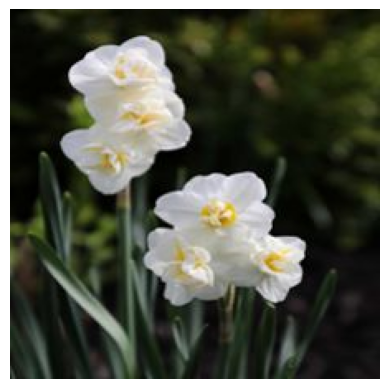

In [6]:
for img, _ in train_ds.take(1):
    import matplotlib.pyplot as plt
    plt.imshow(img[0].numpy())
    plt.axis('off')
    plt.show()

In [7]:
EPOCHS_HEAD = 8
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(models_dir / "head_best.keras"),
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True
    ),
]
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
)


Epoch 1/8
  8/322 [..............................] - ETA: 3:17 - loss: 4.1303 - accuracy: 0.0273

C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\plantenv\lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


322/322 [==============================] - ETA: 0s - loss: 2.8497 - accuracy: 0.2825
Epoch 1: val_accuracy improved from -inf to 0.45175, saving model to C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\head_best.keras
322/322 [==============================] - 240s 730ms/step - loss: 2.8497 - accuracy: 0.2825 - val_loss: 2.0297 - val_accuracy: 0.4517
Epoch 2/8
322/322 [==============================] - ETA: 0s - loss: 1.7564 - accuracy: 0.5260
Epoch 2: val_accuracy improved from 0.45175 to 0.56158, saving model to C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\head_best.keras
322/322 [==============================] - 234s 727ms/step - loss: 1.7564 - accuracy: 0.5260 - val_loss: 1.6198 - val_accuracy: 0.5616
Epoch 3/8
322/322 [==============================] - ETA: 0s - loss: 1.4408 - accuracy: 0.6079
Epoch 3: val_accuracy improved from 0.56158 to 0.61811, saving model to C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\head_best.keras
322/322 [========

In [8]:
# Unfreeze tail
for layer in base.layers[:-40]:
    layer.trainable = False
for layer in base.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

EPOCHS_FT = 10
callbacks_ft = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(models_dir / "finetune_best.keras"),
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1
    ),
]
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    callbacks=callbacks_ft,
)


Epoch 1/10
322/322 [==============================] - ETA: 0s - loss: 1.0398 - accuracy: 0.7089
Epoch 1: val_accuracy improved from -inf to 0.70450, saving model to C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\finetune_best.keras
322/322 [==============================] - 234s 714ms/step - loss: 1.0398 - accuracy: 0.7089 - val_loss: 1.0417 - val_accuracy: 0.7045 - lr: 1.0000e-04
Epoch 2/10
322/322 [==============================] - ETA: 0s - loss: 1.0077 - accuracy: 0.7199
Epoch 2: val_accuracy improved from 0.70450 to 0.71094, saving model to C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\finetune_best.keras
322/322 [==============================] - 227s 703ms/step - loss: 1.0077 - accuracy: 0.7199 - val_loss: 1.0324 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 3/10
322/322 [==============================] - ETA: 0s - loss: 0.9976 - accuracy: 0.7219
Epoch 3: val_accuracy did not improve from 0.71094
322/322 [==============================] - 228s 708ms/step

In [9]:
# ======================================================
# ✅ Load and save the BEST fine-tuned model
# ======================================================

from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np

# Load the best fine-tuned checkpoint (highest val_accuracy)
best_model_path = models_dir / "finetune_best.keras"
if best_model_path.exists():
    print(f"Loading best fine-tuned model from: {best_model_path}")
    model = load_model(best_model_path)
else:
    print("⚠️ finetune_best.keras not found. Using current in-memory model instead.")

# Evaluate on test set
print("\nEvaluating best model on test data...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Save final SavedModel (used for TFLite conversion)
final_saved = models_dir / "plant_classifier_savedmodel"
model.save(final_saved, include_optimizer=False)
print(f"✅ SavedModel exported to: {final_saved}")

# Save labels (important for inference)
labels_path = models_dir / "labels.txt"
with open(labels_path, "w", encoding="utf-8") as f:
    for cls in classes:
        f.write(cls + "\n")
print(f"✅ Label file saved to: {labels_path}")


Loading best fine-tuned model from: C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\finetune_best.keras

Evaluating best model on test data...
70/70 [==============================] - 30s 397ms/step - loss: 1.0045 - accuracy: 0.7156
✅ Test Accuracy: 0.7156 | Test Loss: 1.0045


INFO:tensorflow:Assets written to: C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\plant_classifier_savedmodel\assets


INFO:tensorflow:Assets written to: C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\plant_classifier_savedmodel\assets


✅ SavedModel exported to: C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\plant_classifier_savedmodel
✅ Label file saved to: C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\labels.txt


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

# Collect predictions on test set
y_true, y_pred = [], []
for imgs, labels in test_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar(im)
ax.set_title("Confusion Matrix (Test Set)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

tick_marks = np.arange(len(classes))
if len(classes) <= 25:
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes)
else:
    step = max(1, len(classes)//25)
    ax.set_xticks(tick_marks[::step])
    ax.set_yticks(tick_marks[::step])
    ax.set_xticklabels(classes[::step], rotation=90)
    ax.set_yticklabels(classes[::step])

plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=classes, digits=3))

# Misclassified examples
wrong_idx = np.where(y_pred != y_true)[0]
if len(wrong_idx) > 0:
    sample_idx = np.random.choice(wrong_idx, size=min(9, len(wrong_idx)), replace=False)
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(sample_idx):
        imgs_batch, _ = next(iter(test_ds.skip(idx // BATCH_SIZE).take(1)))
        img = imgs_batch[idx % BATCH_SIZE].numpy().astype(np.uint8)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("🎉 No misclassified examples found in this test subset!")


KeyboardInterrupt: 

In [12]:
converter = tf.lite.TFLiteConverter.from_saved_model(str(final_saved))
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_fp16 = converter.convert()

fp16_path = models_dir / "plant_classifier_fp16.tflite"
with open(fp16_path, "wb") as f:
    f.write(tflite_fp16)
print("✅ TFLite FP16 model saved at:", fp16_path)

✅ TFLite FP16 model saved at: C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\models\plant_classifier_fp16.tflite


In [ ]:
def representative_dataset_gen():
    sample = random.sample(train_paths, min(200, len(train_paths)))
    for p in sample:
        img = safe_load(p, IMG_SIZE).astype(np.float32)
        img = tf.keras.applications.mobilenet_v3.preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        yield [img]

converter = tf.lite.TFLiteConverter.from_saved_model(str(final_saved))
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int8 = converter.convert()
int8_path = models_dir / "plant_classifier_int8.tflite"
with open(int8_path, "wb") as f:
    f.write(tflite_int8)
print("✅ TFLite INT8 model saved at:", int8_path)
